## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
ha = pd.read_csv("C:\\Users\\young\\OneDrive\\文档\GSB544\\9-1 practice activity\\ha_1.csv")

In [2]:
ha.head(5)

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [3]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       204 non-null    object
 1   age        204 non-null    int64 
 2   sex        204 non-null    int64 
 3   cp         204 non-null    int64 
 4   trtbps     204 non-null    int64 
 5   chol       204 non-null    int64 
 6   restecg    204 non-null    int64 
 7   thalach    204 non-null    int64 
 8   diagnosis  204 non-null    object
dtypes: int64(7), object(2)
memory usage: 14.5+ KB


In [4]:
missing_data = ha.isnull().sum()
missing_data

Name         0
age          0
sex          0
cp           0
trtbps       0
chol         0
restecg      0
thalach      0
diagnosis    0
dtype: int64

In [10]:
ha_num = pd.get_dummies(ha, columns=["diagnosis"], drop_first=True, dtype="int64")
ha_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Name                  204 non-null    object
 1   age                   204 non-null    int64 
 2   sex                   204 non-null    int64 
 3   cp                    204 non-null    int64 
 4   trtbps                204 non-null    int64 
 5   chol                  204 non-null    int64 
 6   restecg               204 non-null    int64 
 7   thalach               204 non-null    int64 
 8   diagnosis_No Disease  204 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 14.5+ KB


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [24]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import numpy as np

X = sm.ad1d_constant(ha_num[["age", "chol"]])  #adds an intercept column
y = 1 - ha_num["diagnosis_No Disease"]

model = sm.Logit(y, X).fit(disp=False)

print(model.params)

const    3.240693
age     -0.046876
chol    -0.001801
dtype: float64


In [30]:
#when age is 55(defalut cutoff=0.5),

Esta= model.params['const'] + model.params['age']*55
Estimate_chol = -eta / model.params['chol']
print(Estimate_chol)

# cutoff is changed to 0.9
chol_90 = (np.log(0.9/0.1) - eta) / b_chol
print(chol_90)


367.9046028080374
-852.2935594422362


Analysis: 

- 367.90 → the cholesterol cutoff at age 55 for p(disease)=0.5 (the decision boundary).
- 90% is not achievable (model would require chol ≈ −852 mg/dL which is impossible)

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X = ha_num[["age", "chol"]]
y = 1 - ha_num["diagnosis_No Disease"]

lda = LinearDiscriminantAnalysis(solver='svd')   
lda.fit(X, y)

b = lda.intercept_[0]
chol_55 = -(b + lda.coef_[0, X.columns.get_loc('age')]*55) / lda.coef_[0, X.columns.get_loc('chol')]
print(chol_55)


368.235357529938


Analysis:
368.24 mg/dL is the LDA cutoff at age 55 for a 50% posterior of disease

##3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=False, random_state=0))
param_grid = {'svc__C': np.logspace(-3, 3, 13)}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)

print("Best C:", gs.best_params_['svc__C'], "CV score:", gs.best_score_)

svc = gs.best_estimator_.named_steps['svc']
sc  = gs.best_estimator_.named_steps['standardscaler']

w_age_s, w_chol_s = svc.coef_[0]
b_s = svc.intercept_[0]

# Convert to original feature space
mu_age, mu_chol   = sc.mean_
sd_age, sd_chol   = sc.scale_
w_age = w_age_s / sd_age
w_chol = w_chol_s / sd_chol
b = b_s - (w_age_s * mu_age / sd_age + w_chol_s * mu_chol / sd_chol)

age = 55
chol_needed = -(b + w_age * age) / w_chol
print(f"{float(chol_needed):.1f}")


Best C: 10.0 CV score: 0.5982926829268294
312.7


Analysis:

With the tuned linear SVC, the cholesterol level for a 55-year-old is: 312.7 mg/dL

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

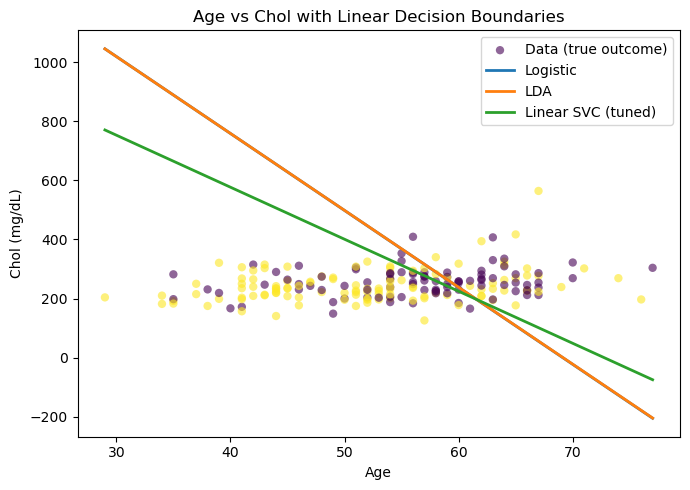

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


age_min, age_max = X['age'].min(), X['age'].max()
age_grid = np.linspace(age_min, age_max, 200)

# Logistic 
b0 = model.params.get('const', model.params.get('Intercept'))
b_age = model.params['age']
b_chol = model.params['chol']

def line_from_linear(b, w_age, w_chol, xs):
    if np.isclose(w_chol, 0.0):
        return None, -b / w_age  
    return -(b + w_age*xs) / w_chol, None

chol_logit, x_vert_logit = line_from_linear(b0, b_age, b_chol, age_grid)

#  LDA 
i_age  = X.columns.get_loc('age')
i_chol = X.columns.get_loc('chol')
w_age_lda  = lda.coef_[0, i_age]
w_chol_lda = lda.coef_[0, i_chol]
b_lda      = lda.intercept_[0]
chol_lda, x_vert_lda = line_from_linear(b_lda, w_age_lda, w_chol_lda, age_grid)

# Linear SVC 
sc  = gs.best_estimator_.named_steps['standardscaler']
svc = gs.best_estimator_.named_steps['svc']

w_age_s, w_chol_s = svc.coef_[0]
b_s = svc.intercept_[0]
w_age_svc  = w_age_s  / sc.scale_[0]
w_chol_svc = w_chol_s / sc.scale_[1]
b_svc = b_s - (w_age_svc*sc.mean_[0] + w_chol_svc*sc.mean_[1])
chol_svc, x_vert_svc = line_from_linear(b_svc, w_age_svc, w_chol_svc, age_grid)


plt.figure(figsize=(7,5))
plt.scatter(X['age'], X['chol'], c=y, alpha=0.6, edgecolor='none', label='Data (true outcome)')
plt.xlabel('Age'); plt.ylabel('Chol (mg/dL)')
plt.title('Age vs Chol with Linear Decision Boundaries')

# Logistic
if chol_logit is None:
    plt.axvline(x=x_vert_logit, linewidth=2, label='Logistic')
else:
    plt.plot(age_grid, chol_logit, linewidth=2, label='Logistic')

# LDA
if chol_lda is None:
    plt.axvline(x=x_vert_lda, linewidth=2, label='LDA')
else:
    plt.plot(age_grid, chol_lda, linewidth=2, label='LDA')

# SVC
if chol_svc is None:
    plt.axvline(x=x_vert_svc, linewidth=2, label='Linear SVC (tuned)')
else:
    plt.plot(age_grid, chol_svc, linewidth=2, label='Linear SVC (tuned)')

plt.legend()
plt.tight_layout()
plt.show()
